# 03. Data Preprocessing

## Objective
- Clean the dataset
- Prepare the data for feature engineering

## 1. Setup and Load Dataset

In [38]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Add project root to path
import os
import sys
sys.path.append(os.path.abspath('../'))
from src.data_loader import load_raw_data

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

print(f"✓ Python version: {sys.version.split()[0]}")
print(f"✓ Pandas version: {pd.__version__}")
print(f"✓ NumPy version: {np.__version__}")

✓ Python version: 3.10.11
✓ Pandas version: 2.1.4
✓ NumPy version: 1.26.4


In [4]:
# Load raw data using custom loader
try:
    df = load_raw_data()
    print(f"✓ Data loaded successfully")
    print(f"  Shape: {df.shape}")
    print(f"  Period: {df.index.min()} to {df.index.max()}")
    print(f"  Frequency: {df.index.freq if df.index.freq else 'Not set (likely 15min)'}")
except Exception as e:
    print(f"❌ Error: {e}")

👉 Loading: C:\EP16\Time Series Analysis and Forecasting\project\Electricity-Load-Diagrams\data\raw\electricity_data.parquet
✅ Data loaded successfully!
📊 Samples: 140256
👥 Number of customers: 370
🕒 Time span: 2011-01-01 00:15:00 → 2015-01-01 00:00:00
✓ Data loaded successfully
  Shape: (140256, 370)
  Period: 2011-01-01 00:15:00 to 2015-01-01 00:00:00
  Frequency: Not set (likely 15min)


## 2. Missing Value Handling

- The dataset contains no missing values. Therefore, forward fill or interpolation is not required.
- Even though there are no missing values, duplicates still needed to verified.

In [5]:
# Check duplicate rows
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Remove duplicates if any
df = df.drop_duplicates()

Number of duplicate rows: 0


Zero-Value:  Structural Zeros and True Zeros
- The pre-install zero affecting mean, outliers,... so they need to be cleaned

--- STARTING ZERO VALUE ANALYSIS ---
Total Data Points: 51,894,720
Total Zero Values: 10,457,342
Percentage of Zeros: 20.15%


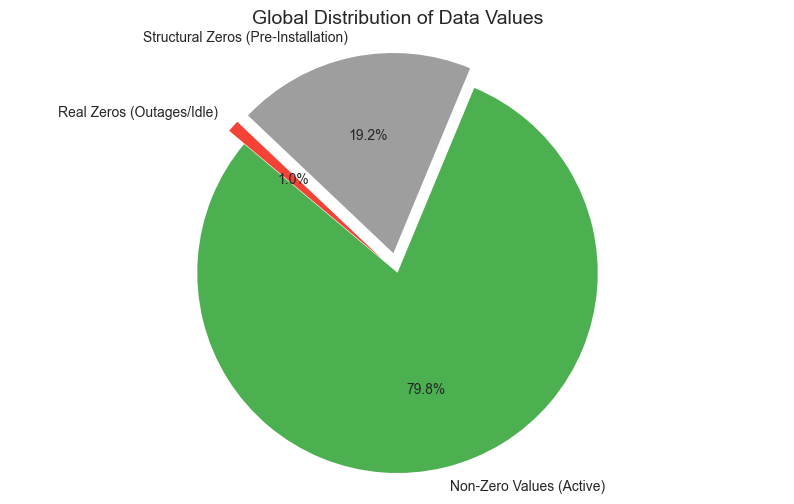

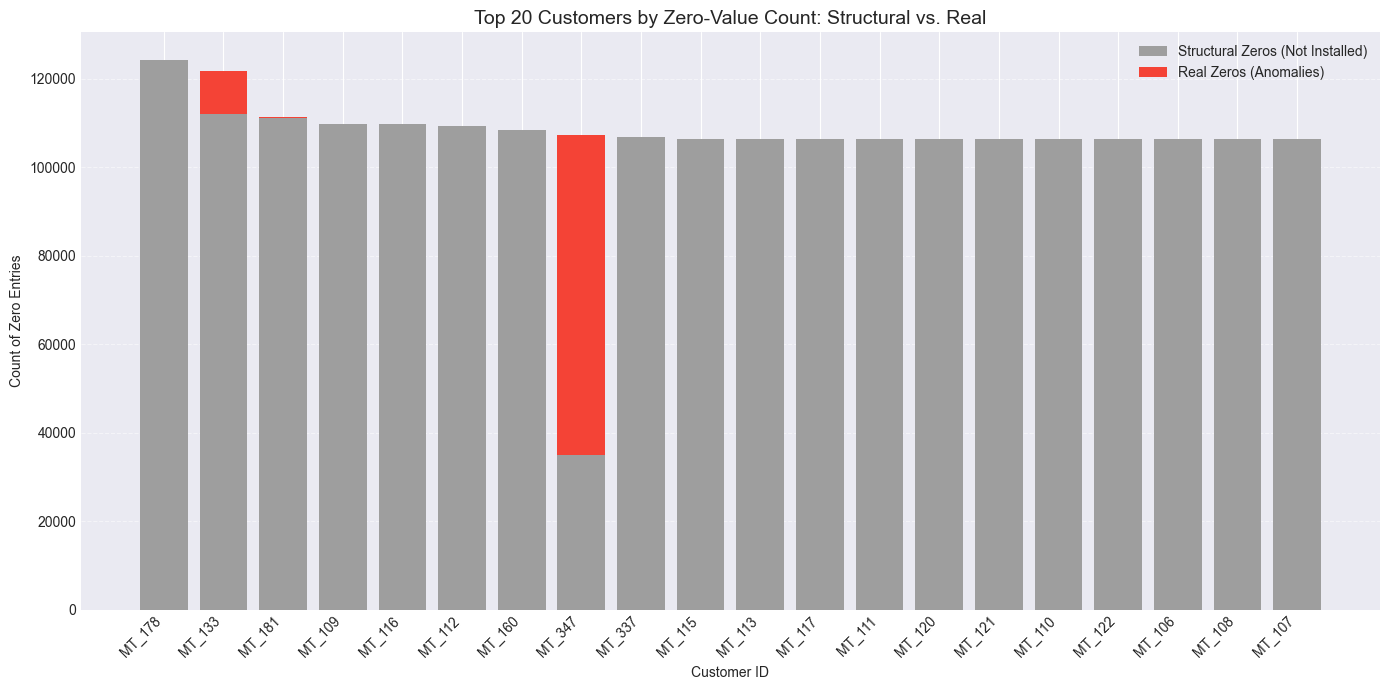

In [8]:
print("--- STARTING ZERO VALUE ANALYSIS ---")
    
# 1. Global Statistics
total_cells = df.size
total_zeros = (df == 0).sum().sum()
zero_percentage = (total_zeros / total_cells) * 100
    
print(f"Total Data Points: {total_cells:,}")
print(f"Total Zero Values: {total_zeros:,}")
print(f"Percentage of Zeros: {zero_percentage:.2f}%")
    
# 2. Classification: Structural (Pre-meter) vs. Real (Outages/Idle)
structural_zeros = 0
real_zeros = 0
    
customer_stats = []

for col in df.columns:
    series = df[col]
        
    # logic: If cumulative sum is 0, it means we haven't seen any usage yet.
    is_structural = (series.cumsum() == 0)
        
    n_structural = is_structural.sum()
        
    # Real zeros are 0 values occurring AFTER the first non-zero value
    n_real = ((series == 0) & (~is_structural)).sum()
        
    structural_zeros += n_structural
    real_zeros += n_real
        
    customer_stats.append({
        'Customer': col,
        'Structural_Zeros': n_structural,
        'Real_Zeros': n_real,
        'Total_Rows': len(series)
    })

# Create DataFrame for visualization
zero_df = pd.DataFrame(customer_stats)
zero_df['Total_Zeros'] = zero_df['Structural_Zeros'] + zero_df['Real_Zeros']

# --- VISUALIZATION 1: Global Distribution (Pie Chart) ---
non_zeros = total_cells - total_zeros
labels = ['Non-Zero Values (Active)', 'Structural Zeros (Pre-Installation)', 'Real Zeros (Outages/Idle)']
sizes = [non_zeros, structural_zeros, real_zeros]
colors = ['#4CAF50', '#9E9E9E', '#F44336'] # Green, Gray, Red
explode = (0, 0.1, 0.1)  

plt.figure(figsize=(10, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Global Distribution of Data Values', fontsize=14)
plt.axis('equal') 
plt.show()

# --- VISUALIZATION 2: Top 20 Customers with Zeros (Stacked Bar) ---
top_zeros = zero_df.sort_values('Total_Zeros', ascending=False).head(20)

plt.figure(figsize=(14, 7))
    
# Bar 1: Structural (Gray)
plt.bar(top_zeros['Customer'], top_zeros['Structural_Zeros'], label='Structural Zeros (Not Installed)', color='#9E9E9E')
    
# Bar 2: Real (Red) - Stacked on top
plt.bar(top_zeros['Customer'], top_zeros['Real_Zeros'], bottom=top_zeros['Structural_Zeros'], label='Real Zeros (Anomalies)', color='#F44336')

plt.title('Top 20 Customers by Zero-Value Count: Structural vs. Real', fontsize=14)
plt.ylabel('Count of Zero Entries')
plt.xlabel('Customer ID')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
print("--- REMOVING PRE-INSTALL (STRUCTURAL) ZEROS ---")
    
df_cleaned = df.copy()
structural_zeros_total = 0
    
for col in df.columns:
    series = df[col]
        
    # Structural zeros = values before first non-zero
    is_structural = (series.cumsum() == 0)
    structural_zeros_total += is_structural.sum()
        
    # Replace structural zeros with NaN
    df_cleaned.loc[is_structural, col] = np.nan
    
print(f"Total Structural Zeros Removed: {structural_zeros_total:,}")

--- REMOVING PRE-INSTALL (STRUCTURAL) ZEROS ---
Total Structural Zeros Removed: 9,958,262
Cleaned dataset saved as: ../data\cleaned\cleaned.parquet


## 3. Outlier Analysis

In [59]:
# Z-score method
z_scores = (df_cleaned - df_cleaned.mean()) / df_cleaned.std()

outliers = (np.abs(z_scores) > 3)

# Total number of valid (non-NaN) values
total_valid = df_cleaned.notna().sum().sum()

# Total outliers
total_outliers = outliers.sum().sum()

# Percentage
outlier_percentage = (total_outliers / total_valid) * 100

print("Number of detected outliers:", total_outliers)
print(f"Percentage of outliers: {outlier_percentage:.4f}%")

Number of detected outliers: 160940
Percentage of outliers: 0.3838%


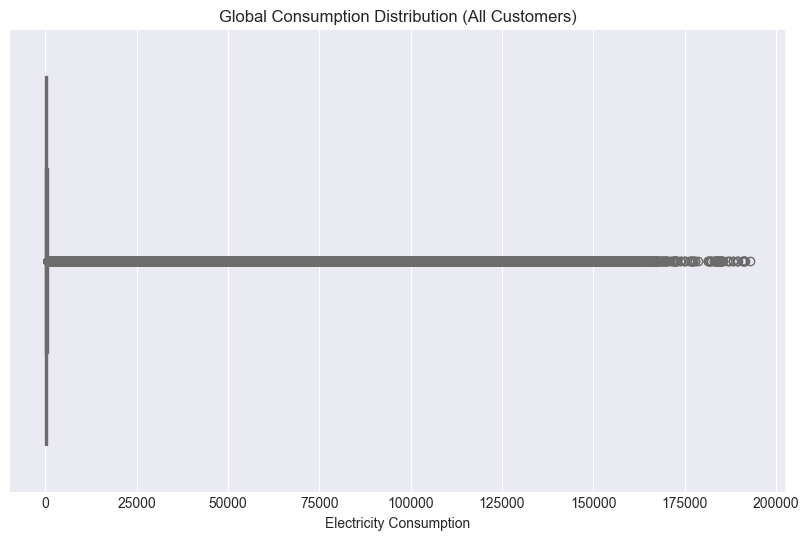

In [19]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=df_cleaned.values.flatten())

plt.title("Global Consumption Distribution (All Customers)")
plt.xlabel("Electricity Consumption")
plt.show()

C:\Temp\ipykernel_17268\1644287129.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_outliers_20.values, y=top_outliers_20.index, palette='viridis')


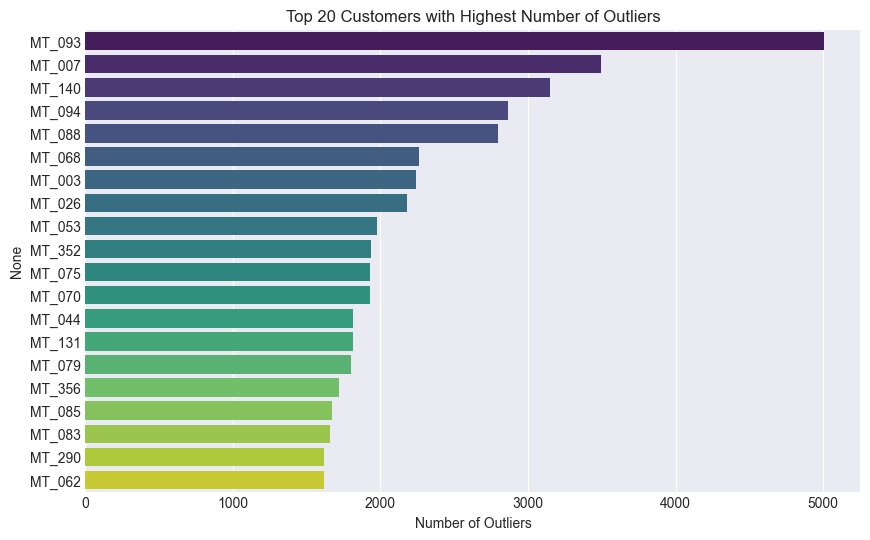

In [22]:
# Number of outlier for each customer
outlier_counts = (np.abs(z_scores) > 3).sum()

# Top 20 customer with the most outliers
top_outliers_20 = outlier_counts.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_outliers_20.values, y=top_outliers_20.index, palette='viridis')
plt.title('Top 20 Customers with Highest Number of Outliers')
plt.xlabel('Number of Outliers')
plt.show()

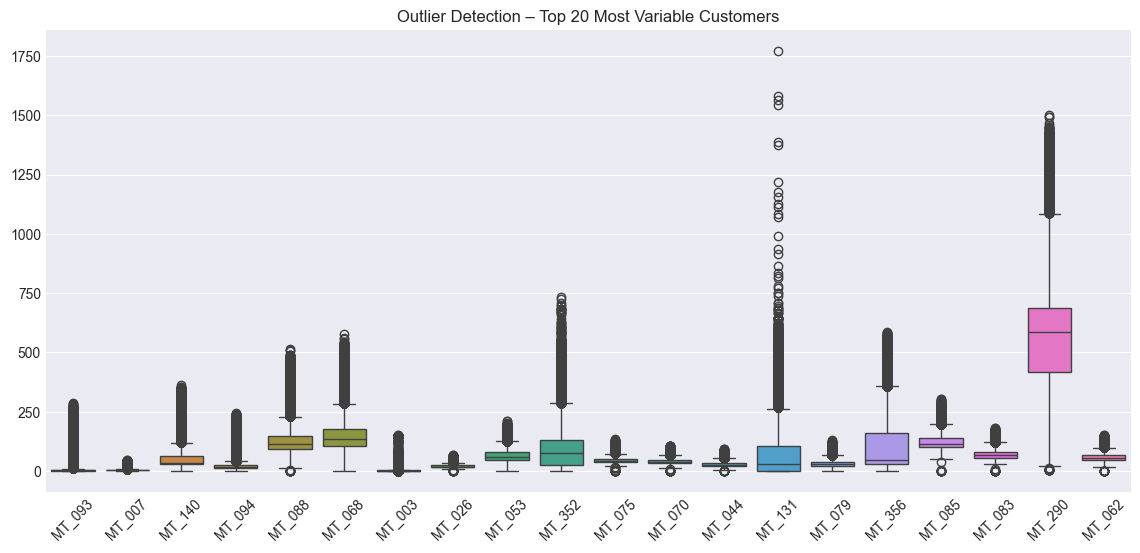

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_cleaned[top_outliers_20.index])

plt.title("Outlier Detection - Top 20 Most Variable Customers")
plt.xticks(rotation=45)
plt.show()

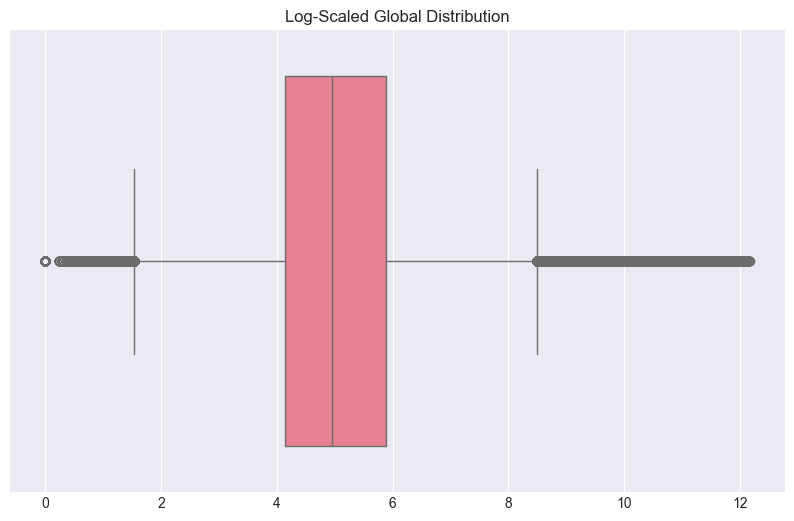

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=np.log1p(df_cleaned.values.flatten()))
plt.title("Log-Scaled Global Distribution")
plt.show()

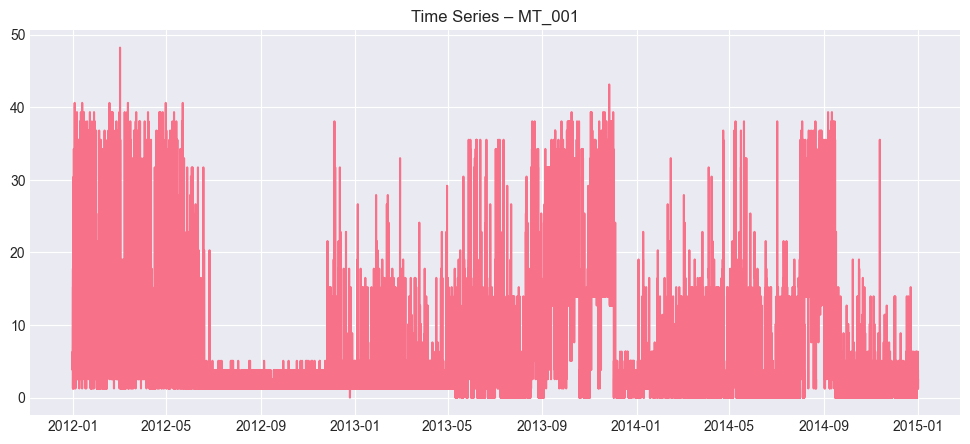

In [46]:
customer = df_cleaned.columns[0]

plt.figure(figsize=(12, 5))
plt.plot(df_cleaned[customer])
plt.title(f"Time Series – {customer}")
plt.show()

## 4. Time Index Processing

In [27]:
# Try setting 15-minute frequency
df_cleaned = df_cleaned.asfreq("15T")

print("Frequency after setting:", df_cleaned.index.freq)

Frequency after setting: <15 * Minutes>


## 5. Train-Test Split Strategy
In this project, we use a time-based 80–20 split:
- First 80% (earliest timestamps) → Training set
- Last 20% (most recent timestamps) → Testing set

This approach preserves the chronological order of the data and reflects real-world conditions, where models are trained on past observations and evaluated on future data.

In [47]:
# Determine split index (80%)
split_index = int(len(df_cleaned) * 0.8)

# Time-based split
train_df = df_cleaned.iloc[:split_index]
test_df  = df_cleaned.iloc[split_index:]

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (112204, 370)
Test shape: (28052, 370)


## 6. Scaling (If Needed)
Scaling is applied to ensure that all customer electricity consumption values are on a comparable scale before modeling.

To prevent data leakage:
- The dataset is not shuffled
- Preprocessing steps (e.g., scaling) are fitted only on the training set
- No future information is used during feature engineering

This ensures reliable and realistic model evaluation for time-series electricity consumption data.

In this project, Standardization is preferred because:
1. Electricity consumption varies significantly between customers
2. Anomalies are being detected using Z-score and Bollinger Bands
3. Data contains extreme spikes (attacks/outliers)
4. Distribution is skewed (not bounded between 0 and 1)

Standardization:
- Preserves anomaly magnitude
- Works naturally with statistical detection
- Does not compress spikes like Min-Max scaling

In [51]:
print("Columns with all NaN in training set:")
print(train_df.columns[train_df.isna().all()])

Columns with all NaN in training set:
Index(['MT_178'], dtype='object')


In [52]:
# Remove customers with no training data
valid_columns = train_df.columns[~train_df.isna().all()]

train_df = train_df[valid_columns]
test_df  = test_df[valid_columns]

print("Remaining customers:", len(valid_columns))

Remaining customers: 369


In [53]:
# Initialize scaler
scaler = StandardScaler()

# Fit ONLY on training data
scaler.fit(train_df)

# Transform both sets
train_scaled = pd.DataFrame(
    scaler.transform(train_df),
    index=train_df.index,
    columns=train_df.columns
)

test_scaled = pd.DataFrame(
    scaler.transform(test_df),
    index=test_df.index,
    columns=test_df.columns
)

print("Standardization complete.")

Standardization complete.


In [56]:
print("Train mean (should be ~0):")
print(train_scaled.mean().round(2).head())

print("\nTest mean (NOT necessarily 0):")
print(test_scaled.mean().round(2).head())

Train mean (should be ~0):
MT_001   -0.0
MT_002    0.0
MT_003   -0.0
MT_004    0.0
MT_005    0.0
dtype: float64

Test mean (NOT necessarily 0):
MT_001   -0.17
MT_002   -0.17
MT_003   -0.20
MT_004    0.22
MT_005   -0.12
dtype: float64


## Save data

In [57]:
def save_file(df, file_path):
    save_dir = "../data"
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, file_path)
    df.to_parquet(save_path, index=True)
    print(f"File saved as: {save_path}")

In [58]:
save_file(df_cleaned, "cleaned/electricity_data_cleaned.parquet")
save_file(train_df, "cleaned/electricity_train.parquet")
save_file(test_df, "cleaned/electricity_test.parquet")
save_file(train_scaled, "cleaned/train_scaled.parquet")
save_file(test_scaled, "cleaned/test_scaled.parquet")

File saved as: ../data\cleaned/electricity_data_cleaned.parquet
File saved as: ../data\cleaned/electricity_train.parquet
File saved as: ../data\cleaned/electricity_test.parquet
File saved as: ../data\cleaned/train_scaled.parquet
File saved as: ../data\cleaned/test_scaled.parquet


## 7. Conclusion
- Dữ liệu sẵn sàng cho feature engineering